In [1]:
from pathlib import Path
import numpy as np
import datetime
import json
import os
import pandas as pd
import rasterio
from PIL import Image
from cropmask.coco_convert import split_save_train_validation_test_df, save_coco_annotation, create_coco_dataset
from cropmask.misc import parse_yaml, make_dirs

from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.
from detectron2.data.datasets import register_coco_instances, load_coco_json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor, launch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale
from cropmask.detectron2_cropmask_cfg import cfg
from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.

tiles_path = Path(cfg.DATASET_PATH) / "tiles"
train, validation, test = split_save_train_validation_test_df(tiles_path, save_empty_tiles=False)
coco_path = Path(cfg.DATASET_PATH) / "coco"

def read_and_mean(path):
    arr = rasterio.open(path).read()
    fill_values = np.mean(arr, axis=tuple(range(1, arr.ndim)))
    return fill_values
    
def read_and_variance(path):
    arr = rasterio.open(path).read()
    fill_values = np.var(arr, axis=tuple(range(1, arr.ndim)))
    return fill_values

def calc_stat(df, func, include_empty=False):
    """
    func should operate on a single array of order [band, H, W]
    """
    df = df.copy()
    new_df = df[df.is_empty == include_empty]
    new_df['fill_values'] = new_df['image_tiles'].apply(func)
    new_df = pd.DataFrame(new_df.fill_values.tolist(), columns=['0', '1', '2'])
    return new_df

def max_norm_channels(arr):
    """
    arr must be of shape (w, h, channel)
    """
    arr = arr.copy()
    maxes = np.nanmax(arr, axis=(0,1))
    return arr / maxes

def make_vis_im(img):
    img = img[:, :, ::-1]
    normalized = max_norm_channels(np.where(img < 0, 0, img))
    rescaled = rescale_intensity(normalized, out_range=(0,255))
    masked = np.where(rescaled==0, np.nan, rescaled)
    return masked

mean_df = calc_stat(train, read_and_mean)
var_df = calc_stat(train, read_and_variance)

channel_means = mean_df.mean(axis=0).values
channel_stds = np.sqrt(var_df.mean(axis=0).values)

train_coco_instances_path = str(coco_path / "instances_train.json")
val_coco_instances_path = str(coco_path / "instances_val.json")
test_coco_instances_path = str(coco_path / "instances_test.json")

/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/pyt

In [2]:
if (coco_path / "instances_train.json").exists() is False:
    train_coco_dict = create_coco_dataset(train)
    val_coco_dict = create_coco_dataset(validation)
    test_coco_dict = create_coco_dataset(test)
    save_coco_annotation(train_coco_instances_path, train_coco_dict)
    save_coco_annotation(val_coco_instances_path, val_coco_dict)
    save_coco_annotation(test_coco_instances_path, test_coco_dict)
# register each val and test set if there are more than one.
register_coco_instances(cfg.DATASETS.TRAIN[0], {}, train_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances(cfg.DATASETS.VALIDATION[0], {}, val_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances(cfg.DATASETS.TEST[0], {}, test_coco_instances_path, str(next(tiles_path.glob("*image*"))))

train_json = load_coco_json(train_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
val_json = load_coco_json(val_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
test_json = load_coco_json(test_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
try:
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)
except:
    pass

[02/17 02:59:35 d2.data.datasets.coco]: Loading /datadrive/test-ard-june-sept-nirrg/coco/instances_train.json takes 1.81 seconds.
[02/17 02:59:35 d2.data.datasets.coco]: Loaded 377 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_train.json
[02/17 02:59:35 d2.data.datasets.coco]: Loaded 42 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_val.json
[02/17 02:59:35 d2.data.datasets.coco]: Loaded 47 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_test.json


In [3]:
print(channel_means)
print(channel_stds)

[ 931.90757125 1001.46930161 2793.30379383]
[262.82447442 340.61644907 559.11205354]


### Printing Truth Labels and Images

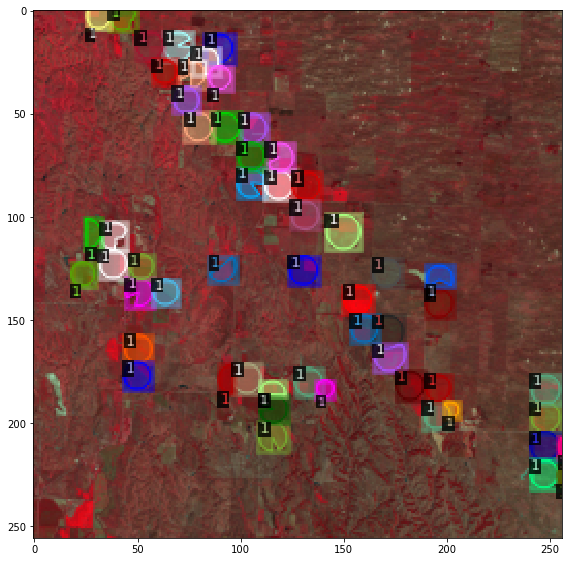

In [4]:

for d in random.sample(train_json, 1):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        img = img[:, :, ::-1]
        normalized = max_norm_channels(np.where(img < 0, 0, img))
        rescaled = rescale_intensity(normalized, out_range=(0,255))
        masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(masked, metadata={}, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (8,16))
        imshow(vis.get_image())

# Model Inspection

In [5]:
cfg.OUTPUT_DIR

'/datadrive/cropmask_experiments/nirrg-nms7/'

In [6]:
cfg.OUTPUT_DIR = "/datadrive/cropmask_experiments/rgb"

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0003999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

'proposal_generator.anchor_generator.cell_anchors.0' has shape (3, 4) in the checkpoint but (12, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.1' has shape (3, 4) in the checkpoint but (12, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.2' has shape (3, 4) in the checkpoint but (12, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.3' has shape (3, 4) in the checkpoint but (12, 4) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.4' has shape (3, 4) in the checkpoint but (12, 4) in the model! Skipped.
'proposal_generator.rpn_head.objectness_logits.weight' has shape (3, 256, 1, 1) in the checkpoint but (12, 256, 1, 1) in the model! Skipped.
'proposal_generator.rpn_head.objectness_logits.bias' has shape (3,) in the checkpoint but (12,) in the model! Skipped.
'proposal_generator.rpn_head.anchor_deltas.weight' has shape (12, 256, 1, 1) in the checkpoint but (48, 256, 1, 1) in the mod

In [11]:
rescale_intensity


<function skimage.exposure.exposure.rescale_intensity(image, in_range='image', out_range='dtype')>

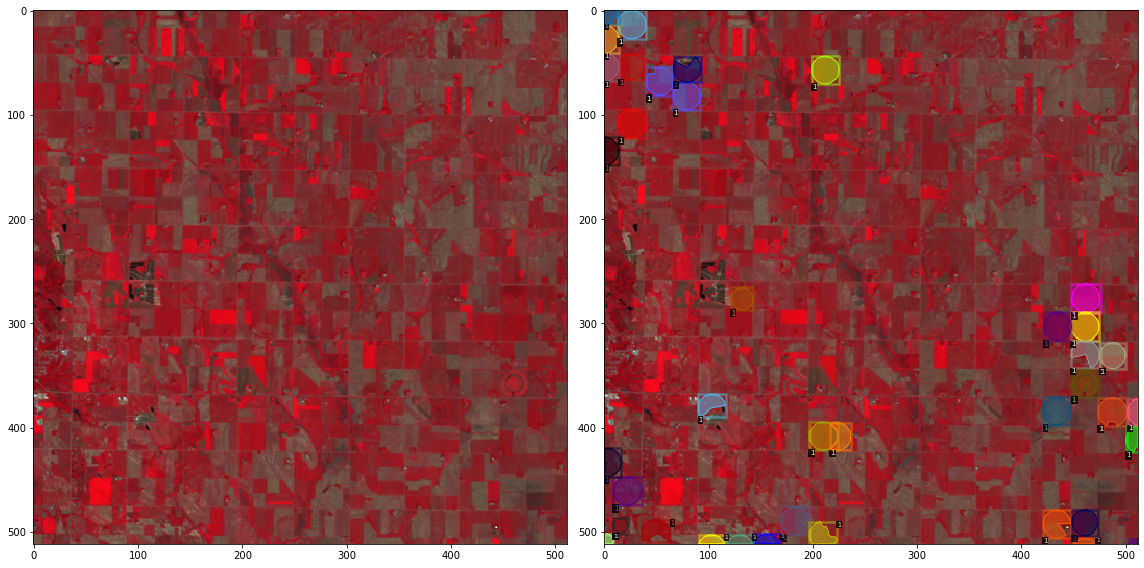

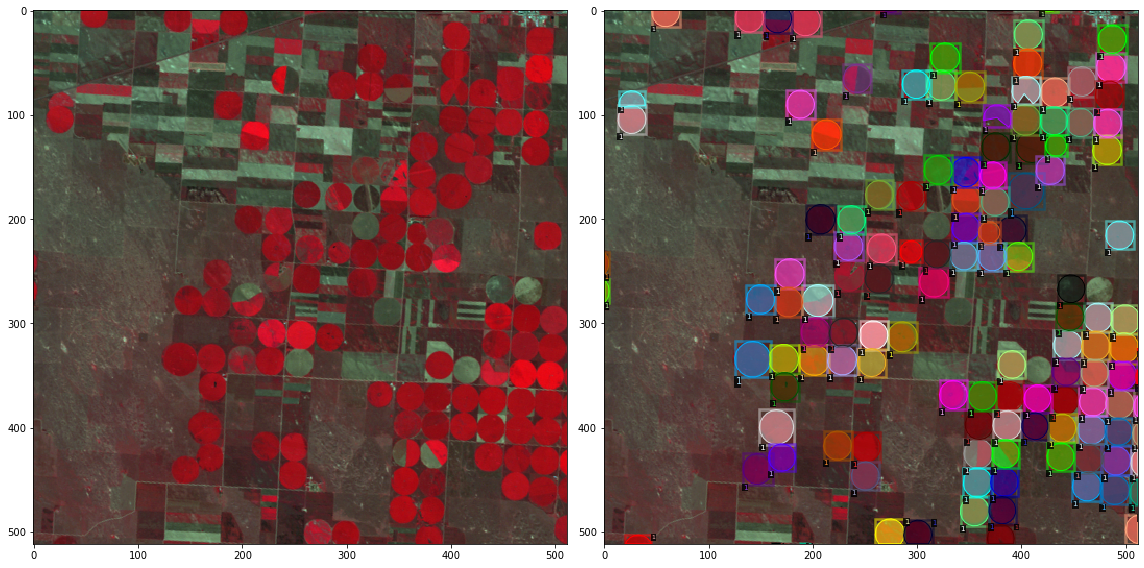

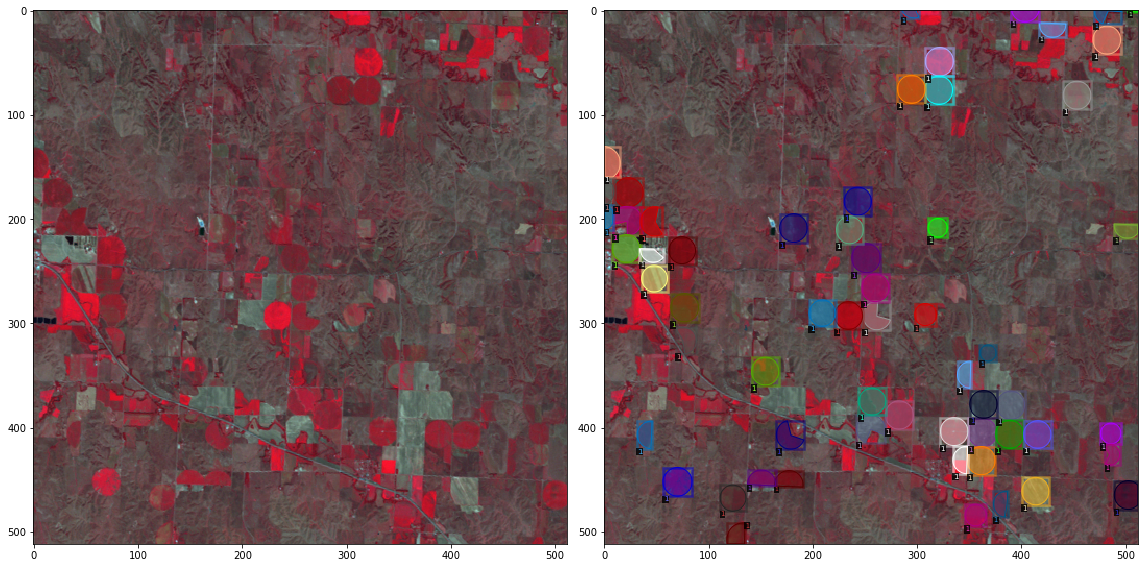

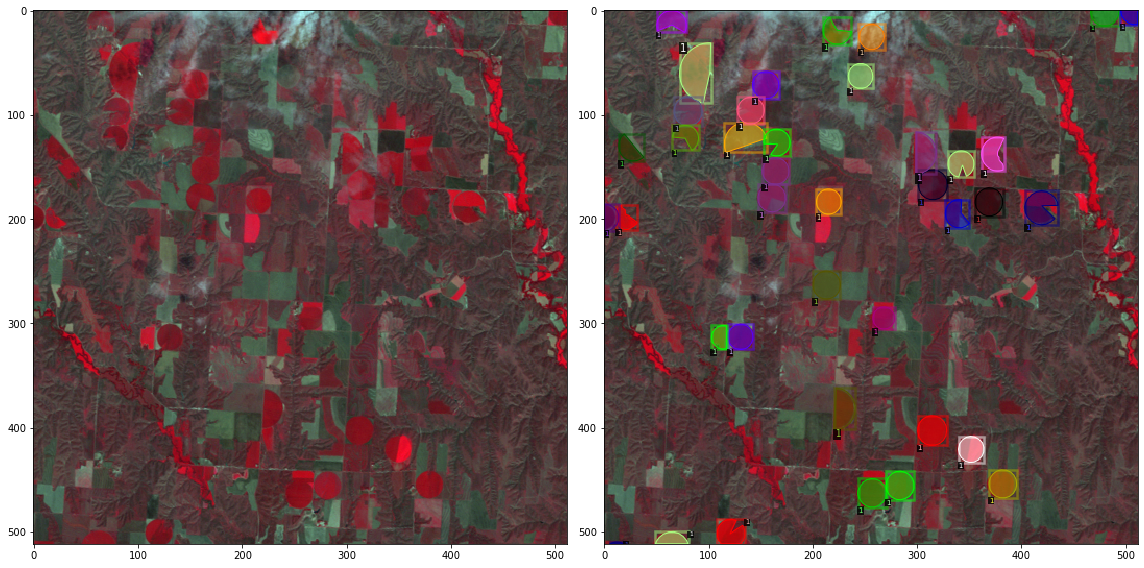

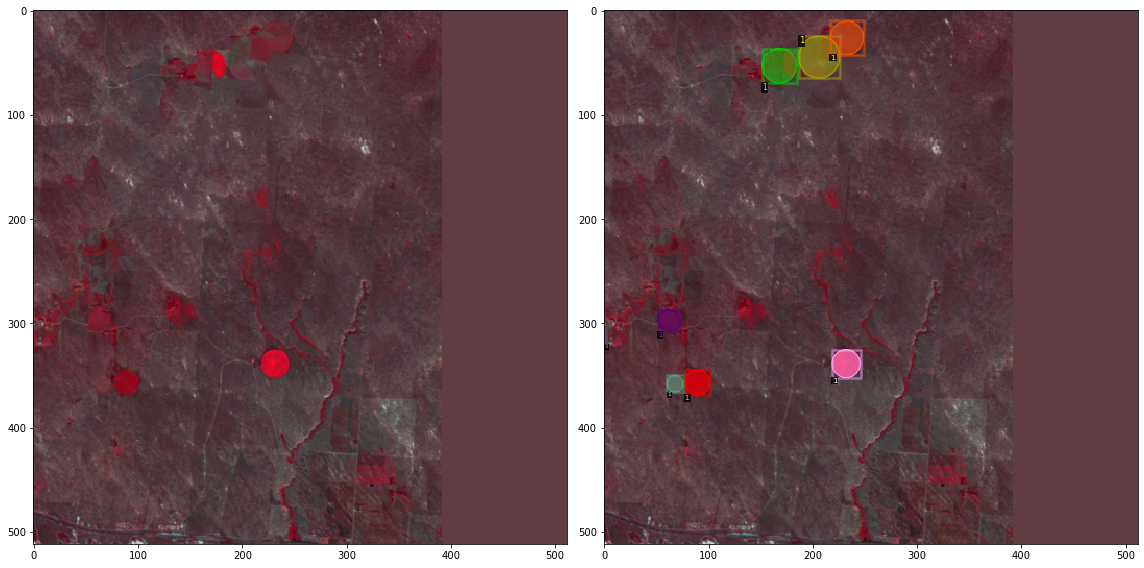

In [12]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(train_json, 5):    
    im = imread(d["file_name"])
    outputs = predictor(im)
    vis_im = make_vis_im(im)
    visualizer_preds = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    visualizer_labels = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    v = visualizer_preds.draw_instance_predictions(outputs["instances"].to("cpu"))
    labels = visualizer_labels.draw_dataset_dict(d)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,16))
    imshow(v.get_image(), ax=ax[0])
    imshow(labels.get_image(), ax=ax[1])

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test", cfg, False, output_dir="/datadrive/evaluator_output/")
test_loader = build_detection_test_loader(cfg, "test")

[02/17 03:01:40 d2.data.datasets.coco]: Loaded 47 images in COCO format from /datadrive/test-ard-june-sept-nirrg/coco/instances_test.json
[02/17 03:01:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   other    | 4234         |
|            |              |


In [10]:
inference_on_dataset(predictor.model, test_loader, evaluator)
# another equivalent way is to use trainer.test

[02/17 03:01:40 d2.evaluation.evaluator]: Start inference on 47 images


OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ryan/detectron2/detectron2/data/common.py", line 39, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
  File "/home/ryan/detectron2/detectron2/utils/serialize.py", line 23, in __call__
    return self._obj(*args, **kwargs)
  File "/home/ryan/detectron2/detectron2/data/dataset_mapper.py", line 77, in __call__
    image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
  File "/home/ryan/detectron2/detectron2/data/detection_utils.py", line 49, in read_image
    image = Image.open(f)
  File "/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/PIL/Image.py", line 2822, in open
    raise IOError("cannot identify image file %r" % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_014008_20050805_20181227_C01_V0_-434865_1995525.tif'>
